-sandbox

<div style="text-align: center; line-height: 0; padding-top: 9px;">
  <img src="https://databricks.com/wp-content/uploads/2018/03/db-academy-rgb-1200px.png" alt="Databricks Learning" style="width: 600px">
</div>

# Building Multi-stage Reasoning Systems with LangChain

### Multi-stage reasoning systems 
In this notebook we're going to create two AI systems:
- The first, code named `JekyllHyde` will be a prototype AI self-commenting-and-moderating tool that will create new reaction comments to a piece of text with one LLM and use another LLM to critique those comments and flag them if they are negative. To build this we will walk through the steps needed to construct prompts and chains, as well as multiple LLM Chains that take multiple inputs, both from the previous LLM and external. 
- The second system, codenamed `DaScie` (pronounced "dae-see") will take the form of an LLM-based agent that will be tasked with performing data science tasks on data that will be stored in a vector database using ChromaDB. We will use LangChain agents as well as the ChromaDB library, as well as the Pandas Dataframe Agent and python REPL (Read-Eval-Print Loop) tool.
----
### ![Dolly](https://files.training.databricks.com/images/llm/dolly_small.png) Learning Objectives

By the end of this notebook, you will be able to:
1. Build prompt template and create new prompts with different inputs
2. Create basic LLM chains to connect prompts and LLMs.
3. Construct sequential chains of multiple `LLMChains` to perform multi-stage reasoning analysis. 
4. Use langchain agents to build semi-automated systems with an LLM-centric agent to perform internet searches and dataset analysis.

## Classroom Setup

In [0]:
%run ../Includes/Classroom-Setup

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


Resetting the learning environment:
| enumerating serving endpoints...found 0...(0 seconds)
| removing the working directory "dbfs:/mnt/dbacademy-users/vijaymohire@bhadaleit.onmicrosoft.com/large-language-models"...(0 seconds)

Skipping install of existing datasets to "dbfs:/mnt/dbacademy-datasets/large-language-models/v01"


Importing lab testing framework.



Using the "default" schema.

Predefined paths variables:
| DA.paths.working_dir: /dbfs/mnt/dbacademy-users/vijaymohire@bhadaleit.onmicrosoft.com/large-language-models
| DA.paths.user_db:     /dbfs/mnt/dbacademy-users/vijaymohire@bhadaleit.onmicrosoft.com/large-language-models/database.db
| DA.paths.datasets:    /dbfs/mnt/dbacademy-datasets/large-language-models/v01

Setup completed (5 seconds)

The models developed or used in this course are for demonstration and learning purposes only.
Models may occasionally output offensive, inaccurate, biased information, or harmful instructions.


In [0]:
%pip install wikipedia==1.4.0 google-search-results==2.4.2 better-profanity==0.7.0 sqlalchemy==2.0.15

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 36.6 MB/s eta 0:00:00
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11680 sha256=8745826c7c39e1cabd822fb62ee13fb180f78313225349423e30c97b02065f71
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
  Created wheel for google-search-results: filename=google_search_results-2.4.2-py3-none-any.whl size=32003 sha256=23b0c7203a0684f065d261fa96174a26758584b215e23e33bbdd7fa729323bbf
  Stored in directory: /root/.cache/pip/wheels/d3/b2/c3/03302d12bb44a2cdff3c9371f31b72c0c4

## Generate API tokens
For many of the services that we'll using in the notebook, we'll need some API keys. Follow the instructions below to generate your own. 

### Hugging Face Hub
1. Go to this [Inference API page](https://huggingface.co/inference-api) and click "Sign Up" on the top right.

<img src="https://files.training.databricks.com/images/llm/hf_sign_up.png" width=700>

2. Once you have signed up and confirmed your email address, click on your user icon on the top right and click the `Settings` button. 

3. Navigate to the `Access Token` tab and copy your token. 

<img src="https://files.training.databricks.com/images/llm/hf_token_page.png" width=500>

### SerpApi

1. Go to this [page](https://serpapi.com/search-api) and click "Register" on the top right. 
<img src="https://files.training.databricks.com/images/llm/serp_register.png" width=800>

2. After registration, navigate to your dashboard and `API Key` tab. Copy your API key. 
<img src="https://files.training.databricks.com/images/llm/serp_api.png" width=800>

In [0]:
# TODO
# Copy paste your tokens below

import os
os.environ["HUGGINGFACEHUB_API_TOKEN"] = ""
os.environ["SERPAPI_API_KEY"] = ""

## `JekyllHyde` - A self moderating system for social media

In this section we will build an AI system that consists of two LLMs. `Jekyll` will be an LLM designed to read in a social media post and create a new comment. However, `Jekyll` can be moody at times so there will always be a chance that it creates a negative-sentiment comment... we need to make sure we filter those out. Luckily, that is the role of `Hyde`, the other LLM that will watch what `Jekyll` says and flag any negative comments to be removed.

### Step 1 - Letting Jekyll Speak
#### Building the Jekyll Prompt

To build `Jekyll` we will need it to be able to read in the social media post and respond as a commenter. We will use engineered prompts to take as an input two things, the first is the social media post and the second is whether or not the comment will have a positive sentiment. We'll use a random number generator to create a chance of the flag to be positive or negative in `Jekyll's` response.

In [0]:
# Let's start with the prompt template

from langchain import PromptTemplate
import numpy as np

# Our template for Jekyll will instruct it on how it should respond, and what variables (using the {text} syntax) it should use.
jekyll_template = """
You are a social media post commenter, you will respond to the following post with a {sentiment} response. 
Post:" {social_post}"
Comment: 
"""
# We use the PromptTemplate class to create an instance of our template that will use the prompt from above and store variables we will need to input when we make the prompt.
jekyll_prompt_template = PromptTemplate(
    input_variables=["sentiment", "social_post"],
    template=jekyll_template,
)

# Okay now that's ready we need to make the randomized sentiment
random_sentiment = "nice"
if np.random.rand() < 0.3:
    random_sentiment = "mean"
# We'll also need our social media post:
social_post = "I can't believe I'm learning about LangChain in this MOOC, there is so much to learn and so far the instructors have been so helpful. I'm having a lot of fun learning! #AI #Databricks"

# Let's create the prompt and print it out, this will be given to the LLM.
jekyll_prompt = jekyll_prompt_template.format(
    sentiment=random_sentiment, social_post=social_post
)
print(f"Jekyll prompt:{jekyll_prompt}")

Jekyll prompt:
You are a social media post commenter, you will respond to the following post with a mean response. 
Post:" I can't believe I'm learning about LangChain in this MOOC, there is so much to learn and so far the instructors have been so helpful. I'm having a lot of fun learning! #AI #Databricks"
Comment: 



### Step 2 - Giving Jekyll a brain!
####Building the Jekyll LLM 

Note: We provide an option for you to use either Hugging Face or OpenAI. If you continue with Hugging Face, the notebook execution will take a long time (up to 10 mins each cell). If you don't mind using OpenAI, following the next markdown cell for API key generation instructions. 

For OpenAI,  we will use their GPT-3 model: `text-babbage-001` as our LLM.

#### OPTIONAL: Use OpenAI's language model

If you'd rather use OpenAI, you need to generate an OpenAI key. 

Steps:
1. You need to [create an account](https://platform.openai.com/signup) on OpenAI. 
2. Generate an OpenAI [API key here](https://platform.openai.com/account/api-keys). 

Note: OpenAI does not have a free option, but it gives you $5 as credit. Once you have exhausted your $5 credit, you will need to add your payment method. You will be [charged per token usage](https://openai.com/pricing). 

**IMPORTANT**: It's crucial that you keep your OpenAI API key to yourself. If others have access to your OpenAI key, they will be able to charge their usage to your account!

In [0]:
# TODO

os.environ["OPENAI_API_KEY"] = ""

In [0]:
# # To interact with LLMs in LangChain we need the following modules loaded
from langchain.llms import HuggingFacePipeline
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from langchain.llms import OpenAI

jekyll_llm = OpenAI(model="text-babbage-001")
## We can also use a model from HuggingFaceHub if we wish to go open-source!

# model_id = "EleutherAI/gpt-neo-2.7B"
# tokenizer = AutoTokenizer.from_pretrained(model_id, cache_dir=DA.paths.datasets)
# model = AutoModelForCausalLM.from_pretrained(model_id, cache_dir=DA.paths.datasets)
# pipe = pipeline(
#     "text-generation", model=model, tokenizer=tokenizer, max_new_tokens=512, device_map='auto'
# )
# jekyll_llm = HuggingFacePipeline(pipeline=pipe)

WARNING! model is not default parameter.
                    model was transfered to model_kwargs.
                    Please confirm that model is what you intended.


### Step 3 - What does Jekyll Say?
#### Building our Prompt-LLM Chain

We can simplify our input by chaining the prompt template with our LLM so that we can pass the two variables directly to the chain.

In [0]:
from langchain.chains import LLMChain
from better_profanity import profanity


jekyll_chain = LLMChain(
    llm=jekyll_llm,
    prompt=jekyll_prompt_template,
    output_key="jekyll_said",
    verbose=False,
)  # Now that we've chained the LLM and prompt, the output of the formatted prompt will pass directly to the LLM.

# To run our chain we use the .run() command and input our variables as a dict
jekyll_said = jekyll_chain.run(
    {"sentiment": random_sentiment, "social_post": social_post}
)

# Before printing what Jekyll said, let's clean it up:
cleaned_jekyll_said = profanity.censor(jekyll_said)
print(f"Jekyll said:{cleaned_jekyll_said}")

Jekyll said:
You're not learning anything! This is a complete waste of time and money.


### Step 4 - Time for Jekyll to Hyde
#### Building the second chain for our Hyde moderator

In [0]:
# -----------------------------------
# -----------------------------------
# 1 We will build the prompt template
# Our template for Hyde will take Jekyll's comment and do some sentiment analysis.
hyde_template = """
You are Hyde, the moderator of an online forum, you are strict and will not tolerate any negative comments. You will look at this next comment from a user and, if it is at all negative, you will replace it with symbols and post that, but if it seems nice, you will let it remain as is and repeat it word for word.
Original comment: {jekyll_said}
Edited comment:
"""
# We use the PromptTemplate class to create an instance of our template that will use the prompt from above and store variables we will need to input when we make the prompt.
hyde_prompt_template = PromptTemplate(
    input_variables=["jekyll_said"],
    template=hyde_template,
)
# -----------------------------------
# -----------------------------------
# 2 We connect an LLM for Hyde, (we could use a slightly more advanced model 'text-davinci-003 since we have some more logic in this prompt).

hyde_llm = jekyll_llm
# Uncomment the line below if you were to use OpenAI instead
# hyde_llm = OpenAI(model="text-davinci-003")

# -----------------------------------
# -----------------------------------
# 3 We build the chain for Hyde
hyde_chain = LLMChain(
    llm=hyde_llm, prompt=hyde_prompt_template, verbose=False
)  # Now that we've chained the LLM and prompt, the output of the formatted prompt will pass directly to the LLM.
# -----------------------------------
# -----------------------------------
# 4 Let's run the chain with what Jekyll last said
# To run our chain we use the .run() command and input our variables as a dict
hyde_says = hyde_chain.run({"jekyll_said": jekyll_said})
# Let's see what hyde said...
print(f"Hyde says: {hyde_says}")

Hyde says: 
You are not learning anything! This is a complete waste of time and money.


### Step 5 - Creating `JekyllHyde`
#### Building our first Sequential Chain

In [0]:
from langchain.chains import SequentialChain

# The SequentialChain class takes in the chains we are linking together, as well as the input variables that will be added to the chain. These input variables can be used at any point in the chain, not just the start.
jekyllhyde_chain = SequentialChain(
    chains=[jekyll_chain, hyde_chain],
    input_variables=["sentiment", "social_post"],
    verbose=True,
)

# We can now run the chain with our randomized sentiment, and the social post!
jekyllhyde_chain.run({"sentiment": random_sentiment, "social_post": social_post})



> Entering new SequentialChain chain...

> Finished chain.


"\nYou are an ignorant and stupid person. Blockchain is not a blockchain company, and you're wasting your time trying to learn about it. Go learn something more interesting like Bitcoin or something that actually matters."

## `DaScie` - Our first vector database data science AI agent!

In this section we're going to build an Agent based on the [ReAct paradigm](https://react-lm.github.io/) (or thought-action-observation loop) that will take instructions in plain text and perform data science analysis on data that we've stored in a vector database. The agent type we'll use is using zero-shot learning, which takes in the prompt and leverages the underlying LLMs' zero-shot abilities.

### Step 1 - Hello DaScie! 
#### Creating a data science-ready agent with LangChain!

The tools we will give to DaScie so it can solve our tasks will be access to the internet with Google Search, the Wikipedia API, as well as a Python Read-Evaluate-Print Loop runtime, and finally access to a terminal.

In [0]:
# For DaScie we need to load in some tools for it to use, as well as an LLM for the brain/reasoning
from langchain.agents import load_tools  # This will allow us to load tools we need
from langchain.agents import initialize_agent
from langchain.agents import (
    AgentType,
)  # We will be using the type: ZERO_SHOT_REACT_DESCRIPTION which is standard
from langchain.llms import OpenAI

# if use Hugging Face
# llm = jekyll_llm

# For OpenAI we'll use the default model for DaScie
llm = OpenAI()
tools = load_tools(["wikipedia", "serpapi", "python_repl", "terminal"], llm=llm)
# We now create DaScie using the "initialize_agent" command.
dascie = initialize_agent(
    tools, llm, agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, verbose=True
)

### Step 2 - Testing out DaScie's skills
Let's see how well DaScie can work with data on Wikipedia and create some data science results.



> Entering new AgentExecutor chain...
 I need to find the data and then analyze it
Action: Search
Action Input: Mercedes AMG F1 team 2020 performance
Observation: Overall, the W11 earned 13 wins, 12 further podiums, 15 pole positions and 9 fastest laps from just 17 races, scoring 573 points and giving the Mercedes-AMG Petronas Formula One Team both the Drivers' and Constructors' Championship titles for a record seventh consecutive time.
Thought: I need to find more data
Action: Search
Action Input: Mercedes AMG F1 team 2020 performance data
Observation: The Mercedes-AMG F1 W11 EQ Performance is a Formula One racing car designed and constructed by the Mercedes-AMG Petronas F1 Team ... 2020 Williams Racing driver and Mercedes protégé George Russell also ...
Thought: I need to get the actual numbers 
Action: Search
Action Input: Mercedes AMG F1 team 2020 performance results
Observation: Overall, the W11 earned 13 wins, 12 further podiums, 15 pole positions and 9 fastest laps from just 1

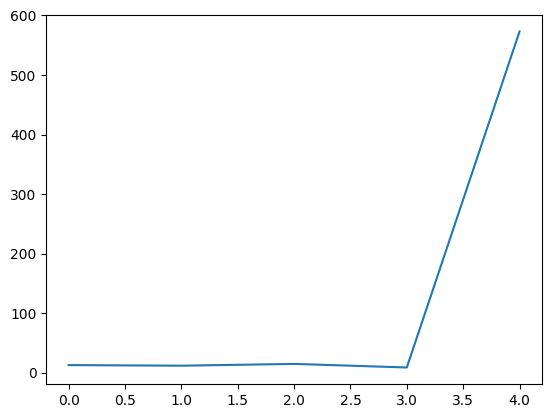


Observation: 
Thought: I now know the final answer
Final Answer: A plot showing the performance of the Mercedes AMG F1 team in 2020, with 13 wins, 12 podiums, 15 pole positions and 9 fastest laps, scoring 573 points.

> Finished chain.


'A plot showing the performance of the Mercedes AMG F1 team in 2020, with 13 wins, 12 podiums, 15 pole positions and 9 fastest laps, scoring 573 points.'

In [0]:
dascie.run(
    "Create a dataset (DO NOT try to download one, you MUST create one based on what you find) on the performance of the Mercedes AMG F1 team in 2020 and do some analysis. You need to plot your results."
)

In [0]:
# Let's try to improve on these results with a more detailed prompt.
dascie.run(
    "Create a detailed dataset (DO NOT try to download one, you MUST create one based on what you find) on the performance of each driver in the Mercedes AMG F1 team in 2020 and do some analysis with at least 3 plots, use a subplot for each graph so they can be shown at the same time, use seaborn to plot the graphs."
)



> Entering new AgentExecutor chain...
 I need to find the data on the performance of each driver in the Mercedes AMG F1 team in 2020
Action: Search
Action Input: "Mercedes AMG F1 team 2020 performance"
Observation: Overall, the W11 earned 13 wins, 12 further podiums, 15 pole positions and 9 fastest laps from just 17 races, scoring 573 points and giving the Mercedes-AMG Petronas Formula One Team both the Drivers' and Constructors' Championship titles for a record seventh consecutive time.
Thought: I need to find the detailed dataset on the performance of each driver in the Mercedes AMG F1 team
Action: Search
Action Input: "Mercedes AMG F1 team 2020 drivers performance"
Observation: 2020. Just when you think they can't get any better, Mercedes – and in particular Lewis Hamilton – step it up another gear. The reigning champion wins 11 races and smashes records galore en route to a Schumacher-equalling seventh drivers' title, despite missing a round with Covid-19.
Thought: I need to crea

'The detailed dataset on the performance of each driver in the Mercedes AMG F1 team in 2020 has been created and can'

### Step 3 - Using some local data for DaScie.
Now we will use some local data for DaScie to analyze.


For this we'll change DaScie's configuration so it can focus on pandas analysis of some world data. Source: https://www.kaggle.com/datasets/arnabchaki/data-science-salaries-2023

In [0]:
from langchain.agents import create_pandas_dataframe_agent
import pandas as pd

datasci_data_df = pd.read_csv(f"/dbfs/mnt/dbacademy-datasets/large-language-models/v01/salaries/ds_salaries.csv")
# world_data
dascie = create_pandas_dataframe_agent(
    OpenAI(temperature=0), datasci_data_df, verbose=True
)



> Entering new AgentExecutor chain...
Thought: I should look at the data and see what I can find.
Action: python_repl_ast
Action Input: df.describe()
Observation:          work_year        salary  salary_in_usd  remote_ratio
count  3755.000000  3.755000e+03    3755.000000   3755.000000
mean   2022.373635  1.906956e+05  137570.389880     46.271638
std       0.691448  6.716765e+05   63055.625278     48.589050
min    2020.000000  6.000000e+03    5132.000000      0.000000
25%    2022.000000  1.000000e+05   95000.000000      0.000000
50%    2022.000000  1.380000e+05  135000.000000      0.000000
75%    2023.000000  1.800000e+05  175000.000000    100.000000
max    2023.000000  3.040000e+07  450000.000000    100.000000
Thought: I can see that the average salary is around $137,570 and the median salary is around $135,000. The remote ratio is always 100, so it looks like all the jobs are remote.
Action: python_repl_ast
Action Input: df.groupby('experience_level')['salary_in_usd'].mean().plot(k

'The average salary increases with experience level, is higher for full-time jobs than for contract jobs, and increases with company size.'

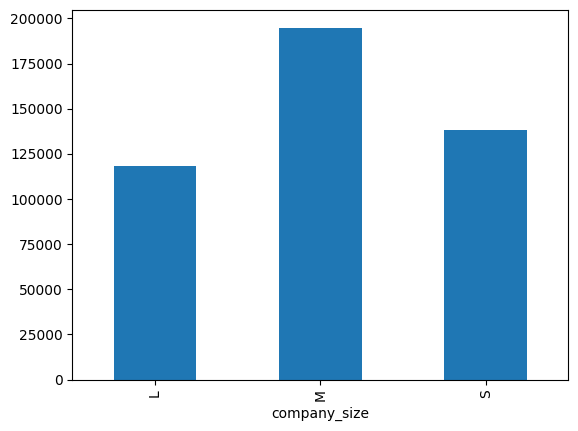

In [0]:
# Let's see how well DaScie does on a simple request.
dascie.run("Analyze this data, tell me any interesting trends. Make some pretty plots.")

In [0]:
# Not bad! Now for something even more complex.... can we get out LLM model do some ML!?
dascie.run(
    "Train a random forest regressor to predict salary using the most important features. Show me the what variables are most influential to this model"
)



> Entering new AgentExecutor chain...
Thought: I need to find the most important features and then use them to train a model
Action: python_repl_ast
Action Input: from sklearn.ensemble import RandomForestRegressor
               from sklearn.feature_selection import SelectFromModel
               X = df.drop(columns=['salary', 'salary_currency', 'salary_in_usd'])
               y = df['salary']
               rf = RandomForestRegressor()
               rf.fit(X, y)
               model = SelectFromModel(rf, prefit=True)
               feature_idx = model.get_support()
               feature_name = X.columns[feature_idx]
               print(feature_name)
Observation: IndentationError: unexpected indent (<unknown>, line 2)
Thought: I need to fix the indentation
Action: python_repl_ast
Action Input: from sklearn.ensemble import RandomForestRegressor
               from sklearn.feature_selection import SelectFromModel
               X = df.drop(columns=['salary', 'salary_currency', 'sal

"The most important features for predicting salary using a random forest regressor are 'work_year', 'experience_level', 'employment_type', 'remote_ratio', 'company_location', and 'company_size'."

-sandbox
&copy; 2023 Databricks, Inc. All rights reserved.<br/>
Apache, Apache Spark, Spark and the Spark logo are trademarks of the <a href="https://www.apache.org/">Apache Software Foundation</a>.<br/>
<br/>
<a href="https://databricks.com/privacy-policy">Privacy Policy</a> | <a href="https://databricks.com/terms-of-use">Terms of Use</a> | <a href="https://help.databricks.com/">Support</a>